In [2]:
%config InlineBackend.rc = {"figure.dpi": 150, "figure.figsize": (12.0, 8.0)}
%matplotlib widget

import abtem
import ase
import matplotlib.pyplot as plt
from ase.io import write
import jax
import jax.numpy as jnp
import numpy as np
from jax_multislice import transmission_function, propagation_kernel, FresnelPropagator, move_probe
import optax
from tqdm.auto import tqdm


(examples:4d-stem_quickstart)=
# 4D-STEM quickstart

In [3]:
abtem.config.set({"device": "cpu"})

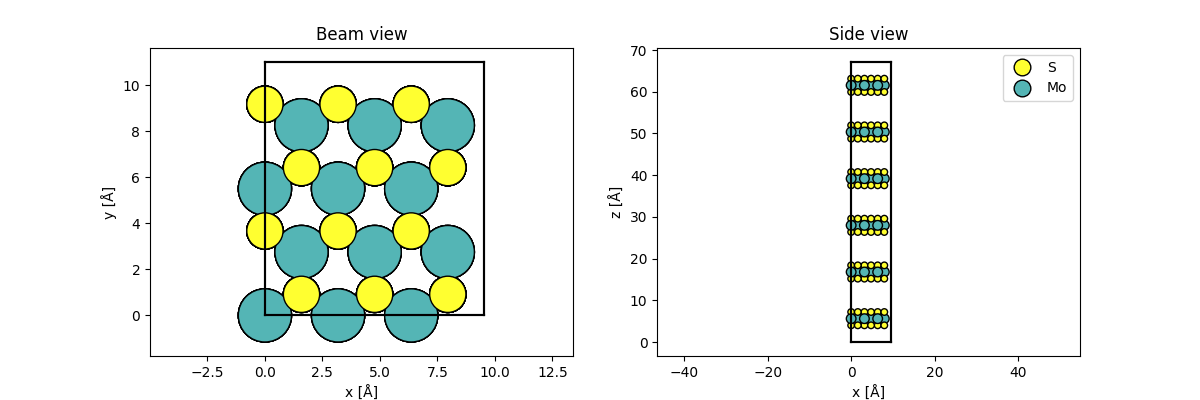

In [4]:
atoms = ase.build.mx2(vacuum=4)
atoms = abtem.orthogonalize_cell(atoms)
atoms *= (3, 2, 6)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True);

In [5]:
potential = abtem.Potential(atoms, sampling=0.2, slice_thickness=5.0, projection='infinite')

print(potential.shape)


(14, 48, 56)


(14, 48, 56)


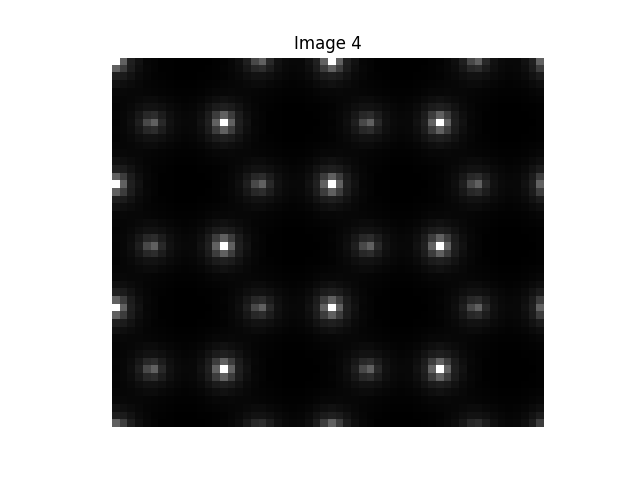

In [6]:
print(potential.shape)
potential_ = potential.to_images()
img = potential_.array[4]

plt.figure()
plt.imshow((jnp.abs(jnp.array(img))), cmap='gray')
plt.title(f'Image {4}')
plt.axis('off')

plt.show()

In [7]:
energy = 80e3
probe = abtem.Probe(energy=energy, semiangle_cutoff=40)
probe.grid.match(potential)

pixels = probe.gpts
pixel_size = probe.sampling

In [8]:
grid_scan = abtem.GridScan(
    start=(0, 0),
    end=(potential.extent[0], potential.extent[1]),
    sampling=probe.aperture.nyquist_sampling,
)

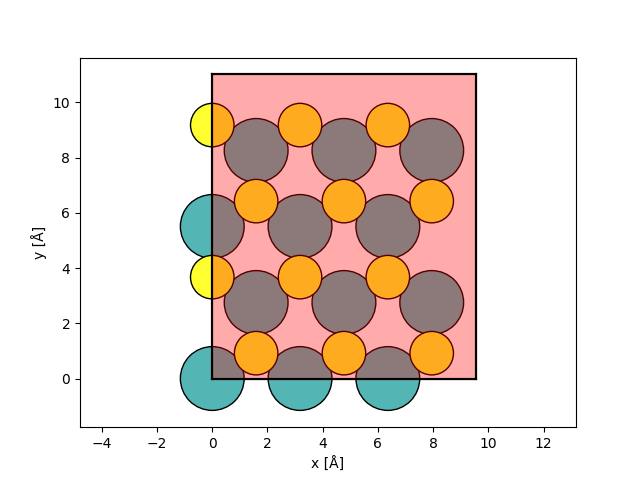

In [9]:
fig, ax = abtem.show_atoms(atoms)

grid_scan.add_to_plot(ax)

In [10]:
detector = abtem.PixelatedDetector(max_angle='full')
measurements = probe.scan(potential, scan=grid_scan, detectors=detector)
probe_array = probe.build(scan=grid_scan)
probe_array = probe_array.compute().array


[                                        ] | 0% Completed | 478.75 us

[########################################] | 100% Completed | 205.95 ms


In [11]:
patterns = measurements.compute()
abtem_patterns = patterns.abs().array
abtem_patterns = abtem_patterns / jnp.sum(abtem_patterns, axis=(2, 3), keepdims=True)

[########################################] | 100% Completed | 1.33 sms


Text(0.5, 1.0, 'ABTEM Potential')

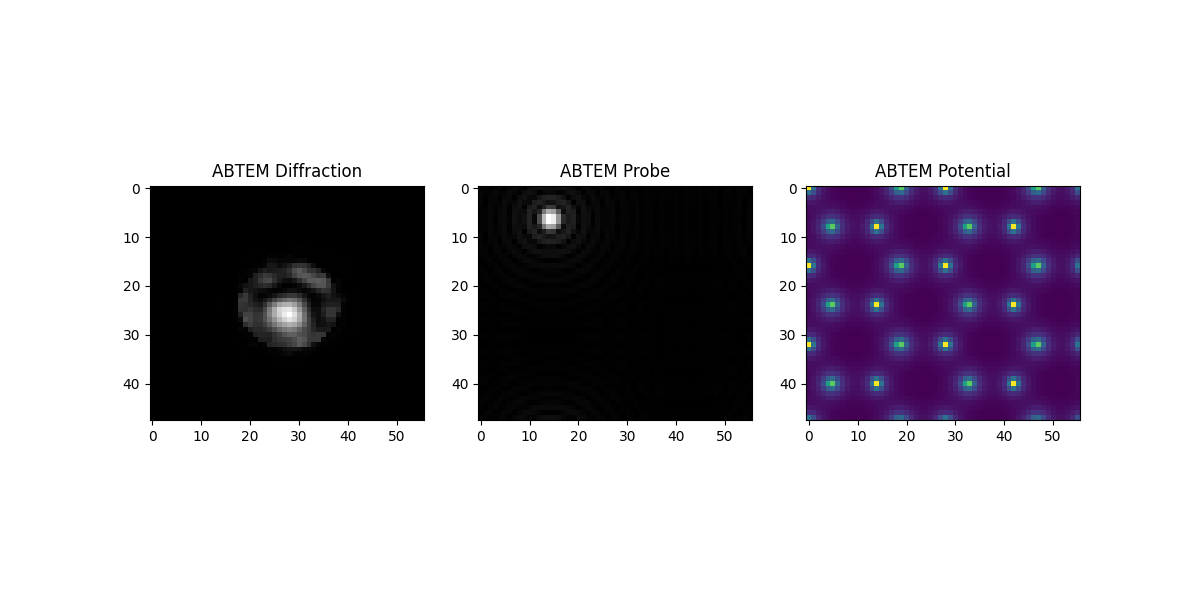

In [12]:
sampling=np.array(potential.sampling)
scan_positions = np.array(grid_scan.get_positions())
scan_positions_px = (scan_positions / sampling).astype(np.int32)

idx_x, idx_y = 5, 11
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(abtem_patterns[idx_x, idx_y], cmap='gray')
ax[0].set_title('ABTEM Diffraction')
ax[1].imshow(np.abs(probe_array[idx_x, idx_y]), cmap='gray')
ax[1].set_title('ABTEM Probe')
ax[2].imshow(np.sum(potential_.array, axis=0))
ax[2].set_title('ABTEM Potential')

In [13]:
probe_array = probe.build()
probe_array = probe_array.compute().array

slice_thickness = jnp.array(potential.slice_thickness[0])
extent=jnp.array(potential.extent)
sampling=jnp.array(potential.sampling)

slices = jnp.array(potential_.array)
probe_ = jnp.array(probe_array)
probe_ = probe_ / jnp.sum(jnp.abs(probe_))

n, m = slices.shape[1::]
# scan_positions = jnp.array([[[n//2, m//2]]])
scan_positions = jnp.array(grid_scan.get_positions())
scan_positions_px = (scan_positions / sampling).astype(jnp.int32)
scan_positions_shape = scan_positions_px.shape[0:2]

print(scan_positions_px)
print(scan_positions_shape)


[                                        ] | 0% Completed | 429.51 us

[########################################] | 100% Completed | 104.67 ms
[[[ 0  0]
  [ 0  1]
  [ 0  2]
  ...
  [ 0 52]
  [ 0 53]
  [ 0 54]]

 [[ 1  0]
  [ 1  1]
  [ 1  2]
  ...
  [ 1 52]
  [ 1 53]
  [ 1 54]]

 [[ 2  0]
  [ 2  1]
  [ 2  2]
  ...
  [ 2 52]
  [ 2 53]
  [ 2 54]]

 ...

 [[44  0]
  [44  1]
  [44  2]
  ...
  [44 52]
  [44 53]
  [44 54]]

 [[45  0]
  [45  1]
  [45  2]
  ...
  [45 52]
  [45 53]
  [45 54]]

 [[46  0]
  [46  1]
  [46  2]
  ...
  [46 52]
  [46 53]
  [46 54]]]
(37, 43)


In [14]:

scan_positions_px = scan_positions_px.reshape(-1, 2)
H = propagation_kernel(n, m, sampling, slice_thickness, energy)


def forward(slices):
    transmission = transmission_function(slices, energy)

    def simulate_pattern(scan_position_px):
        def inner_fn(exit_wave, i):
            exit_wave = FresnelPropagator(exit_wave, H)
            exit_wave = exit_wave * transmission[i]
            return exit_wave, None
        
        probe_shifted = move_probe(probe_, scan_position_px)
        input_wave = probe_shifted * transmission[0]
        
        exit_wave, _ = jax.lax.scan(inner_fn, input_wave, jnp.arange(1, transmission.shape[0]))

        diffraction_pattern = jnp.abs(jnp.fft.fftshift(jnp.fft.fft2(exit_wave)))
        diffraction_pattern = diffraction_pattern / jnp.sum(diffraction_pattern)
        
        return diffraction_pattern

    diffraction_patterns = jax.vmap(simulate_pattern)(scan_positions_px)
    diffraction_patterns = diffraction_patterns.reshape(scan_positions_shape + (n, m))

    return diffraction_patterns


Text(0.5, 1.0, 'ABTEM')

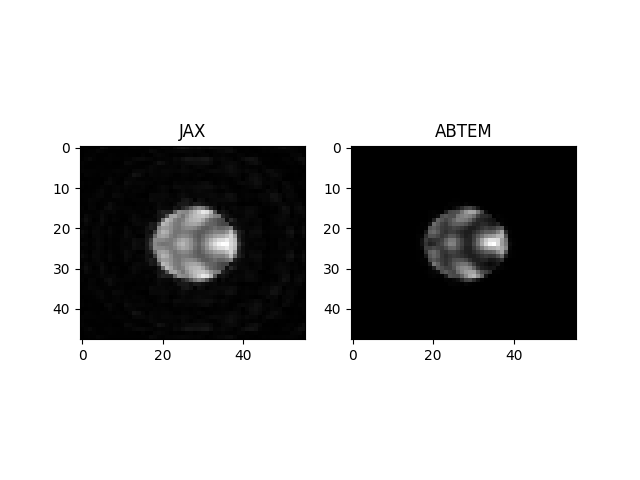

In [15]:
jax_patterns = forward(slices)
scan_position_x, scan_position_y = 25, 32

fig, ax = plt.subplots(1, 2)
ax[0].imshow(jax_patterns[scan_position_x, scan_position_y], cmap='gray')
ax[1].imshow(abtem_patterns[scan_position_x, scan_position_y], cmap='gray')
ax[0].set_title('JAX')
ax[1].set_title('ABTEM')

In [ ]:
@jax.jit
def loss(slices):
    jax_patterns = forward(slices)
    return jnp.sum(jnp.abs(abtem_patterns - jax_patterns)**2)

opt_slices = jnp.zeros_like(potential_.array, dtype=jnp.complex64)

learning_rate = 1e-1
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_slices)

@jax.jit
def update(slices, opt_state):
    loss_val, grads = jax.value_and_grad(loss)(slices)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_slices = optax.apply_updates(slices, updates)
    return new_slices, new_opt_state, loss_val

num_steps = 10000

losses = []
for step in tqdm(range(num_steps)):
    opt_slices, opt_state, current_loss = update(opt_slices, opt_state)
    print(f"Step {step}, loss: {current_loss}")
    losses.append(current_loss)
    
optimized_slices = opt_slices

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 0, loss: 2.03000807762146
Step 1, loss: 2.0292320251464844
Step 2, loss: 2.0284478664398193
Step 3, loss: 2.0276637077331543
Step 4, loss: 2.0268826484680176
Step 5, loss: 2.0261051654815674
Step 6, loss: 2.025331974029541
Step 7, loss: 2.0245633125305176
Step 8, loss: 2.0237996578216553
Step 9, loss: 2.023041248321533
Step 10, loss: 2.022287607192993
Step 11, loss: 2.0215394496917725
Step 12, loss: 2.020796537399292
Step 13, loss: 2.02005934715271
Step 14, loss: 2.0193276405334473
Step 15, loss: 2.018601417541504
Step 16, loss: 2.017880916595459
Step 17, loss: 2.0171661376953125
Step 18, loss: 2.0164575576782227
Step 19, loss: 2.015754222869873
Step 20, loss: 2.01505708694458
Step 21, loss: 2.0143659114837646
Step 22, loss: 2.013680934906006
Step 23, loss: 2.0130014419555664
Step 24, loss: 2.012328624725342
Step 25, loss: 2.0116615295410156
Step 26, loss: 2.011000633239746
Step 27, loss: 2.010345935821533
Step 28, loss: 2.009697437286377
Step 29, loss: 2.0090551376342773
Step 30,